# ADS 505 Final Project - Team 2
## Rent Prediction
### Kiran Singh, Lane Whitmore, Mendelina Lopez

In [38]:
### Package Imports 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import dmba
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import exhaustive_search, regressionSummary
from dmba import stepwise_selection, forward_selection, backward_elimination
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import itertools
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import xgboost as xgb

%matplotlib inline

In [7]:
rent = pd.read_csv(r'C:\Users\whitm\OneDrive\Documents\GitHub\Rent_Prediction/House_Rent_Dataset.csv')

### Data cleanup will entail splitting dates and addressing categorical variables
rent.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


## Pre-Processing

#### Label Encoding

for Area Type, Locality, City, Furnishing, Tenant Preferred, Point of Contact

In [8]:
le_areatype = LabelEncoder()
rent['Area Type'] = le_areatype.fit_transform(rent['Area Type'])

In [9]:
le_arealocality = LabelEncoder()
rent['Area Locality'] = le_arealocality.fit_transform(rent['Area Locality'])

In [10]:
le_city = LabelEncoder()
rent['City'] = le_city.fit_transform(rent['City'])

In [11]:
le_furnish = LabelEncoder()
rent['Furnishing Status'] = le_furnish.fit_transform(rent['Furnishing Status'])

In [12]:
le_tenant = LabelEncoder()
rent['Tenant Preferred'] = le_tenant.fit_transform(rent['Tenant Preferred'])

In [13]:
le_contact = LabelEncoder()
rent['Point of Contact'] = le_contact.fit_transform(rent['Point of Contact'])

In [14]:
### Splitting train and test sets before preprocessing
train, test = train_test_split(rent, test_size = 0.3, random_state = 33)

### Train set predictors & Response
X_train = train.drop('Rent', axis = 1)
y_train = train['Rent']

### Test set predictors & Response
X_test = test.drop('Rent', axis = 1)
y_test = test['Rent']

print('\nTraining Set Length:', len(train))
print('\nTesting Set Length:', len(test))
train.head()


Training Set Length: 3322

Testing Set Length: 1424


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
1698,2022-06-04,2,17000,1000,3 out of 4,2,322,0,1,1,2,2
3924,2022-05-10,2,6500,200,Ground out of 1,1,460,3,2,0,2,2
4375,2022-05-24,2,10000,1200,2 out of 2,2,255,3,2,0,2,2
3910,2022-06-10,2,9500,1140,3 out of 4,2,1412,3,1,1,2,2
3864,2022-05-16,2,14000,1000,2 out of 3,2,423,1,2,1,2,2


The dataset has been split 70/30 train/test and now has been split between predictors and reponse variables before moving into EDA and preprocessing. 

In [15]:
### There are no null values to fill
X_train.isna().sum()

Posted On            0
BHK                  0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

The formulas below extract the numerical values from the Floor predictor creating two predictors that represent the floors the individual is on and the total floors in the building. 
In the UK and India, the ground floor is referred to as the first floor in the U.S. and first floor in the UK and India is the second floor in the U.S..
Therefore, ground floor must be made into 0 and basement has been made into -1.

In [17]:
def clean_flooron(x):
    for i, _ in enumerate(x):
        if 'Gr' in str(x[:2]):
            return 0
        if 'Up' in str(x[:2]):
            return -1
        if 'Lo' in str(x[:2]):
            return -2
        else:
            return str(x[:2])

def clean_floortot(x):
    for i, _ in enumerate(x):
        if 'nd' in str(x[-2:]):
            return 0
        else:
            return str(x[-2:])

In [18]:
### applying formulas to train and test set
X_train['floor on'] = X_train['Floor'].apply(clean_flooron)
X_train['floor total'] = X_train['Floor'].apply(clean_floortot)


X_test['floor on'] = X_test['Floor'].apply(clean_flooron)
X_test['floor total'] = X_test['Floor'].apply(clean_floortot)

X_test.head()

,Posted On,BHK,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,floor on,floor total
998,2022-07-09,2,900,10 out of 15,2,11,5,2,1,2,0,10,15
1945,2022-05-14,1,400,Ground out of 3,2,789,0,1,1,1,2,0,3
1679,2022-06-16,2,1050,1 out of 5,2,756,0,1,1,2,2,1,5
2579,2022-05-18,3,200,1 out of 4,1,1505,2,1,0,3,0,1,4
3374,2022-05-06,2,780,1 out of 2,2,1152,1,0,1,2,2,1,2


In [19]:
### Convert obj to datetime
X_train['Posted On'] = pd.to_datetime(X_train['Posted On'])
X_train['month'] = X_train['Posted On'].dt.month
X_train['year'] = X_train['Posted On'].dt.year
X_train['DOW'] = X_train['Posted On'].dt.dayofweek

X_test['Posted On'] = pd.to_datetime(X_test['Posted On'])
X_test['month'] = X_test['Posted On'].dt.month
X_test['DOW'] = X_test['Posted On'].dt.dayofweek
X_test['year'] = X_test['Posted On'].dt.year

X_train.head()

,Posted On,BHK,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,floor on,floor total,month,year,DOW
1698,2022-06-04,2,1000,3 out of 4,2,322,0,1,1,2,2,3,4,6,2022,5
3924,2022-05-10,2,200,Ground out of 1,1,460,3,2,0,2,2,0,1,5,2022,1
4375,2022-05-24,2,1200,2 out of 2,2,255,3,2,0,2,2,2,2,5,2022,1
3910,2022-06-10,2,1140,3 out of 4,2,1412,3,1,1,2,2,3,4,6,2022,4
3864,2022-05-16,2,1000,2 out of 3,2,423,1,2,1,2,2,2,3,5,2022,0


In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3322 entries, 1698 to 2439
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Posted On          3322 non-null   datetime64[ns]
 1   BHK                3322 non-null   int64         
 2   Size               3322 non-null   int64         
 3   Floor              3322 non-null   object        
 4   Area Type          3322 non-null   int32         
 5   Area Locality      3322 non-null   int32         
 6   City               3322 non-null   int32         
 7   Furnishing Status  3322 non-null   int32         
 8   Tenant Preferred   3322 non-null   int32         
 9   Bathroom           3322 non-null   int64         
 10  Point of Contact   3322 non-null   int32         
 11  floor on           3322 non-null   object        
 12  floor total        3322 non-null   object        
 13  month              3322 non-null   int64         
 14  year 

In [21]:
X_train[['floor on', 'floor total']] = X_train[['floor on', 'floor total']].astype(int)
X_test[['floor on', 'floor total']] = X_test[['floor on', 'floor total']].astype(int)

## EDA 

In [22]:
### Year will be a zero variance variable and therefore can be dropped
X_train[['year']].value_counts()

year
2022    3322
dtype: int64

In [23]:
X_train[['Area Type']].value_counts()

Area Type
2            1688
1            1632
0               2
dtype: int64

In [24]:
X_train[['City']].value_counts()

City
5       707
1       624
0       613
3       593
2       424
4       361
dtype: int64

In [25]:
X_train[['Tenant Preferred']].value_counts()

Tenant Preferred
1                   2392
0                    586
2                    344
dtype: int64

#### Histogram for Continuous Variables

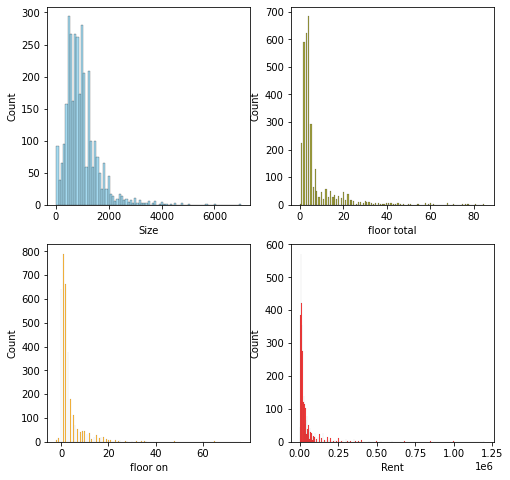

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
sns.histplot(X_train["Size"] , color="skyblue", ax=axes[0,0])
sns.histplot(X_train["floor total"] , color="olive", ax=axes[0,1])
sns.histplot(X_train["floor on"] , color="orange", ax=axes[1,0])
sns.histplot(y_train , color="red", ax=axes[1,1])
plt.show()

#### Correlation Matrix

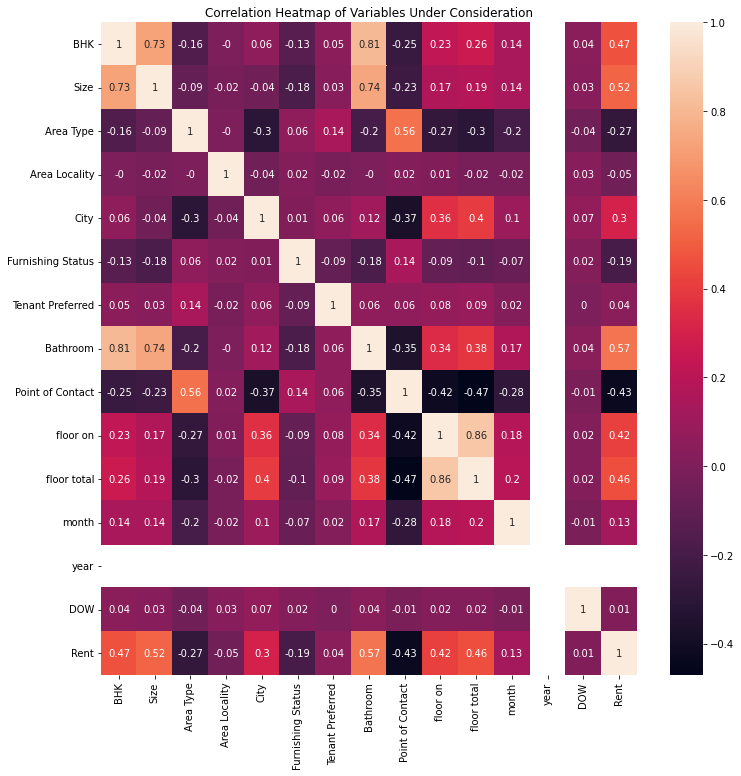

In [28]:
matrix = pd.concat([X_train, y_train], axis = 1).corr().round(2)
plt.figure(figsize=(12,12))
sns.heatmap(matrix, annot=True)
plt.title('Correlation Heatmap of Variables Under Consideration')
plt.show()

#### Scatterplots

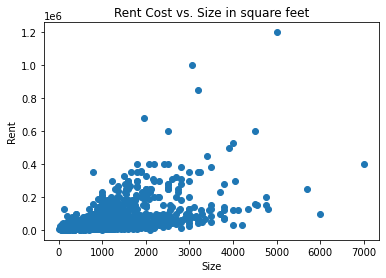

In [29]:
plt.scatter(x = X_train['Size'], y = y_train)
plt.title('Rent Cost vs. Size in square feet')
plt.xlabel('Size')
plt.ylabel('Rent')
plt.show()

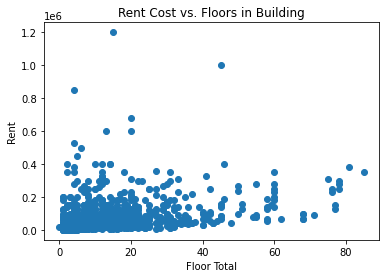

In [30]:
plt.scatter(x = X_train['floor total'], y = y_train)
plt.title('Rent Cost vs. Floors in Building')
plt.xlabel('Floor Total')
plt.ylabel('Rent')
plt.show()

In [31]:
Xmod_train = X_train.drop(['Posted On','Floor','year'], axis = 1)

Xmod_test = X_test.drop(['Posted On','Floor','year'], axis = 1)

Xmod_train.head()

,BHK,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,floor on,floor total,month,DOW
1698,2,1000,2,322,0,1,1,2,2,3,4,6,5
3924,2,200,1,460,3,2,0,2,2,0,1,5,1
4375,2,1200,2,255,3,2,0,2,2,2,2,5,1
3910,2,1140,2,1412,3,1,1,2,2,3,4,6,4
3864,2,1000,2,423,1,2,1,2,2,2,3,5,0


## Feature Extraction

In [32]:
### train model is built to iterate through the variables when performing stepwise regression
def train_model(variables):
    if len(variables) == 0:
        return None
    ### Building linear regression
    Model = LinearRegression()
    Model.fit(Xmod_train[variables], y_train)
    ### Returning the model fit with X amount of variables
    return Model

### Score model calculates the AIC of the models in order to choose the best variables based off of AIC
def score_model(Model, variables):
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), Model, df = 1)
    return AIC_score(y_train, Model.predict(Xmod_train[variables]), Model)

In [33]:
### Using Stepwise selection to extract the best variables
best_model, best_variables = stepwise_selection(Xmod_train.columns, train_model, score_model,
                                               verbose = True)
print(best_variables)

Variables: BHK, Size, Area Type, Area Locality, City, Furnishing Status, Tenant Preferred, Bathroom, Point of Contact, floor on, floor total, month, DOW
Start: score=82714.61, constant
Step: score=81423.82, add Bathroom
Step: score=81058.38, add floor total
Step: score=80869.84, add Size
Step: score=80687.18, add City
Step: score=80609.16, add Point of Contact
Step: score=80583.89, add Furnishing Status
Step: score=80571.13, add month
Step: score=80568.30, add Area Locality
Step: score=80565.19, add floor on
Step: score=80563.48, add DOW
Step: score=80561.58, add Area Type
Step: score=80561.58, unchanged None
['Bathroom', 'floor total', 'Size', 'City', 'Point of Contact', 'Furnishing Status', 'month', 'Area Locality', 'floor on', 'DOW', 'Area Type']


In [34]:
sub_X_train = Xmod_train[['Bathroom','Size', 
                          'City','Point of Contact',
                          'Furnishing Status','month',
                          'Area Locality','floor on',
                          'DOW','Area Type']]

sub_X_test = Xmod_test[['Bathroom','Size', 
                        'City','Point of Contact',
                        'Furnishing Status','month',
                        'Area Locality','floor on',
                        'DOW','Area Type']]

## Model Construction

### Random Forest Regressor

#### Full Dataset

In [35]:
rf_param_grid = {
    'max_depth': [5,10,15,20],
    'min_impurity_decrease': [0,0.001,0.005,0.01],
    'min_samples_split': [10,20,30,40,50]
}
### Using GridSearch Cross Validation to identify best parameters
rf_search = GridSearchCV(RandomForestRegressor(random_state = 33), rf_param_grid, cv = 10, 
                          n_jobs = -1, return_train_score = True)

rf_search.fit(Xmod_train, y_train)
print('\nBest Score:', rf_search.best_score_)
print('\nGeneral Parameters:', rf_search.best_params_)


Best Score: 0.6981481510631657

General Parameters: {'max_depth': 15, 'min_impurity_decrease': 0, 'min_samples_split': 20}


In [36]:
rrf_param_grid = {
    'max_depth': [10,11,12,13,14,15,16,17,18,19],
    'min_impurity_decrease': [0,0.001,0.005,0.01],
    'min_samples_split': [17,18,19,20,21,22,23]
}
### Using GridSearch Cross Validation to identify best parameters
rrf_search = GridSearchCV(RandomForestRegressor(random_state = 33), rrf_param_grid, cv = 10, 
                          n_jobs = -1, return_train_score = True)

rrf_search.fit(Xmod_train, y_train)
print('\nBest Score:', rrf_search.best_score_)
print('\nGeneral Parameters:', rrf_search.best_params_)


Best Score: 0.6994364359399143

General Parameters: {'max_depth': 13, 'min_impurity_decrease': 0, 'min_samples_split': 23}


In [39]:
### Building Random Forest Model based off of parameters
rf = RandomForestRegressor(max_depth = 13, min_impurity_decrease = 0, 
                            min_samples_split = 23, random_state = 33).fit(Xmod_train, y_train)

### rsquared score
regressionSummary(y_test, rf.predict(Xmod_test))
print('\n')
print('r2 Score:', r2_score(y_test, rf.predict(Xmod_test)))


Regression statistics

                      Mean Error (ME) : 2912.6864
       Root Mean Squared Error (RMSE) : 95028.1241
            Mean Absolute Error (MAE) : 12915.7051
          Mean Percentage Error (MPE) : -19.1178
Mean Absolute Percentage Error (MAPE) : 36.1443


r2 Score: 0.21120062429597786


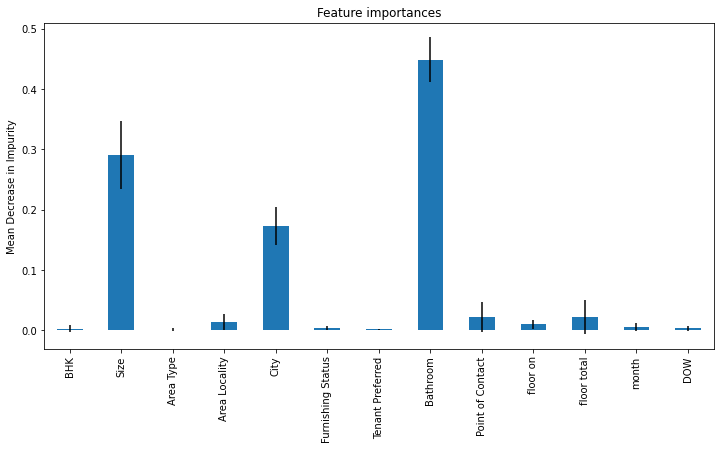

In [40]:
### Looking at the most important features for selection
feature_names = Xmod_train.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(12,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean Decrease in Impurity")
plt.show()

#### Subset Dataset Modeling

In [41]:
srf_param_grid = {
    'max_depth': [5,10,15,20],
    'min_impurity_decrease': [0,0.001,0.005,0.01],
    'min_samples_split': [10,20,30,40,50]
}
### Using GridSearch Cross Validation to identify best parameters
srf_search = GridSearchCV(RandomForestRegressor(random_state = 33), srf_param_grid, cv = 10, 
                          n_jobs = -1, return_train_score = True)

srf_search.fit(sub_X_train, y_train)
print('\nBest Score:', srf_search.best_score_)
print('\nGeneral Parameters:', srf_search.best_params_)


Best Score: 0.6999952234012795

General Parameters: {'max_depth': 15, 'min_impurity_decrease': 0, 'min_samples_split': 20}


In [42]:
srrf_param_grid = {
    'max_depth': [10,11,12,13,14,15,16,17,18,19],
    'min_impurity_decrease': [0,0.001,0.005,0.01],
    'min_samples_split': [17,18,19,20,21,22,23,24]
}
### Using GridSearch Cross Validation to identify best parameters
srrf_search = GridSearchCV(RandomForestRegressor(random_state = 33), srrf_param_grid, cv = 10, 
                           n_jobs = -1, return_train_score = True)

srrf_search.fit(sub_X_train, y_train)
print('\nBest Score:', srrf_search.best_score_)
print('\nGeneral Parameters:', srrf_search.best_params_)


Best Score: 0.7012834727133469

General Parameters: {'max_depth': 14, 'min_impurity_decrease': 0, 'min_samples_split': 18}


In [43]:
### Building Random Forest Model based off of parameters
sub_rf = RandomForestRegressor(max_depth = 14, min_impurity_decrease = 0, 
                               min_samples_split = 18, random_state = 33).fit(sub_X_train, y_train)

### rsquared score
regressionSummary(y_test, sub_rf.predict(sub_X_test))
print('\n')
print('r2 Score:', r2_score(y_test, sub_rf.predict(sub_X_test)))


Regression statistics

                      Mean Error (ME) : 2825.6717
       Root Mean Squared Error (RMSE) : 95053.2341
            Mean Absolute Error (MAE) : 12864.6708
          Mean Percentage Error (MPE) : -19.4581
Mean Absolute Percentage Error (MAPE) : 36.5744


r2 Score: 0.2107837097024522


### MLP Regressor

#### Full Dataset

In [187]:
### Initial gridsearch looking for activation // solver tune
mlp_param_grid = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam','sgd'], 
    'learning_rate_init': [0.01, 0.05, 0.075, 0.1]
}

mlp_search = GridSearchCV(MLPRegressor(random_state = 33, batch_size = 64, max_iter = 2000), mlp_param_grid, 
                          cv = 10, n_jobs = -1)

mlp_search.fit(Xmod_train, y_train)
print('\nGeneral Parameters:', mlp_search.best_params_)

c:\Users\whitm\anaconda3\envs\ads505\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [ 4.90118077e-001              nan  4.97700739e-001              nan
  4.52705986e-001              nan  4.58656973e-001              nan
 -7.13221732e-002 -1.27122544e-002 -7.74630252e-003              nan
 -1.10120024e-002              nan -5.66649688e-002              nan
 -1.29598159e-001 -2.62180484e-001 -4.15032821e-002              nan
 -2.48606605e-002              nan -1.50982733e-002              nan
  6.28355884e-001 -4.20805231e+117  6.02323292e-001 -1.38315686e+152
  5.76193642e-001              nan  5.04999738e-001              nan]
  category=UserWarning



General Parameters: {'activation': 'relu', 'learning_rate_init': 0.01, 'solver': 'adam'}


In [188]:
### GridSearching hyperparameters
rmlp_param_grid = {
    'hidden_layer_sizes': [20, 30, 40, 50, 60, 70, 80, 90, 100],
    'alpha': [0.0001, 0.001, 0.005, 0.01, 0.1]
}

rmlp_search = GridSearchCV(MLPRegressor(activation = 'relu', solver = 'adam', 
                                       learning_rate_init = 0.01, batch_size = 64, 
                                       max_iter = 2000, random_state = 33), 
                           rmlp_param_grid, cv = 10, n_jobs = -1)

rmlp_search.fit(Xmod_train, y_train)
print('\nGeneral Parameters:', rmlp_search.best_params_)


General Parameters: {'alpha': 0.001, 'hidden_layer_sizes': 50}


In [189]:
### Final GridSearch for minute adjustments
cls_param_grid = {
    'hidden_layer_sizes': [45,46,47,48,49,50,51,52,53,54]
}

cls_search = GridSearchCV(MLPRegressor(activation = 'relu', solver = 'adam', alpha = 0.001, 
                                       learning_rate_init = 0.01, batch_size = 64, 
                                       max_iter = 2000, random_state = 33), 
                          cls_param_grid, cv = 10, n_jobs = -1)

cls_search.fit(Xmod_train, y_train)
print('\nGeneral Parameters:', cls_search.best_params_)


General Parameters: {'hidden_layer_sizes': 51}


In [190]:
### Building the final subset predictor model
mlp = MLPRegressor(activation = 'relu', solver = 'adam', 
                   alpha = 0.01, hidden_layer_sizes = 51, 
                   batch_size = 64, max_iter = 2000, 
                   random_state = 33).fit(Xmod_train, y_train)


print('\nr2 Score:', r2_score(y_test, mlp.predict(Xmod_test)))
print('\n')
regressionSummary(y_test, mlp.predict(Xmod_test))


r2 Score: 0.1280210129784498



Regression statistics

                      Mean Error (ME) : 5184.0458
       Root Mean Squared Error (RMSE) : 99912.9742
            Mean Absolute Error (MAE) : 22844.3919
          Mean Percentage Error (MPE) : -26.0356
Mean Absolute Percentage Error (MAPE) : 68.1489


c:\Users\whitm\anaconda3\envs\ads505\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### Stepwise Subset

In [52]:
### Initial gridsearch looking for activation // solver tune
smlp_param_grid = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam','sgd'], 
    'learning_rate_init': [0.01, 0.05, 0.075, 0.1]
}

smlp_search = GridSearchCV(MLPRegressor(random_state = 33, batch_size = 64, max_iter = 2000), smlp_param_grid, 
                          cv = 10, n_jobs = -1)

smlp_search.fit(sub_X_train, y_train)
print('\nGeneral Parameters:', smlp_search.best_params_)

C:\Users\whitm\anaconda3\envs\ads505\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [ 5.09619670e-001              nan  4.86983317e-001              nan
  5.01619261e-001              nan  4.71781644e-001              nan
 -1.14589243e-001 -1.29895023e-001 -6.41154060e-003              nan
 -1.14302200e-002              nan -2.20767880e-002              nan
 -1.13938689e-001 -1.25651746e-001 -7.63533770e-002              nan
 -2.80809767e-002              nan -1.77898367e-002              nan
  6.59787492e-001 -6.18976109e+077  5.64086898e-001 -1.16323610e+114
  5.53439675e-001 -3.57809097e-003  5.43357012e-001 -4.54359189e+010]
  category=UserWarning



General Parameters: {'activation': 'relu', 'learning_rate_init': 0.01, 'solver': 'adam'}


In [191]:
### GridSearching hyperparameters
srmlp_param_grid = {
    'hidden_layer_sizes': [20, 30, 40, 50, 60, 70, 80, 90, 100],
    'alpha': [0.0001, 0.001, 0.005, 0.01, 0.1]
}

srmlp_search = GridSearchCV(MLPRegressor(activation = 'relu', solver = 'adam', 
                                       learning_rate_init = 0.01, batch_size = 64, 
                                       max_iter = 2000, random_state = 33), 
                           srmlp_param_grid, cv = 10, n_jobs = -1)

srmlp_search.fit(sub_X_train, y_train)
print('\nGeneral Parameters:', srmlp_search.best_params_)


General Parameters: {'alpha': 0.005, 'hidden_layer_sizes': 70}


In [54]:
### Final GridSearch for minute adjustments
scls_param_grid = {
    'hidden_layer_sizes': [95,96,97,98,99,100,101,102,103,104]
}

scls_search = GridSearchCV(MLPRegressor(activation = 'relu', solver = 'adam', alpha = 0.001, 
                                        learning_rate_init = 0.01, batch_size = 64, 
                                        max_iter = 2000, random_state = 33), 
                           scls_param_grid, cv = 10, n_jobs = -1)

scls_search.fit(sub_X_train, y_train)
print('\nGeneral Parameters:', scls_search.best_params_)


General Parameters: {'hidden_layer_sizes': 100}


In [192]:
### Building the final subset predictor model
sub_mlp = MLPRegressor(activation = 'relu', solver = 'adam', 
                       alpha = 0.001, hidden_layer_sizes = 100, 
                       batch_size = 64, max_iter = 2000, 
                       random_state = 33).fit(sub_X_train, y_train)


print('\nr2 Score:', r2_score(y_test, sub_mlp.predict(sub_X_test)))
print('\n')
regressionSummary(y_test, sub_mlp.predict(sub_X_test))


r2 Score: 0.17235195816673987



Regression statistics

                      Mean Error (ME) : 2453.2894
       Root Mean Squared Error (RMSE) : 97340.0855
            Mean Absolute Error (MAE) : 17264.1821
          Mean Percentage Error (MPE) : -17.1280
Mean Absolute Percentage Error (MAPE) : 53.4692


### Logistic Regression

#### Full Dataset

In [30]:
logreg_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear', max_iter = 500, random_state = 33)
logreg_full.fit(Xmod_train, y_train)

print('\nr2 Score:', r2_score(y_test, logreg_full.predict(Xmod_test)))
print('\n')
regressionSummary(y_test, logreg_full.predict(Xmod_test))


r2 Score: -0.4595897782191567



Regression statistics

                      Mean Error (ME) : -20329.1538
       Root Mean Squared Error (RMSE) : 129265.9922
            Mean Absolute Error (MAE) : 43246.7521
          Mean Percentage Error (MPE) : -147.3422
Mean Absolute Percentage Error (MAPE) : 177.8186


#### Subset Dataset

In [31]:
logreg_sub = LogisticRegression(penalty="l2", C=1e42, solver='liblinear', max_iter = 500, random_state = 33)
logreg_sub.fit(sub_X_train, y_train)

print('\nr2 Score:', r2_score(y_test, logreg_sub.predict(sub_X_test)))
print('\n')
regressionSummary(y_test, logreg_sub.predict(sub_X_test))


r2 Score: -0.005538622716809716



Regression statistics

                      Mean Error (ME) : 9056.0007
       Root Mean Squared Error (RMSE) : 107292.2260
            Mean Absolute Error (MAE) : 20868.8771
          Mean Percentage Error (MPE) : -6.8088
Mean Absolute Percentage Error (MAPE) : 48.0440


### XGBoost

#### Full Dataset

In [21]:
xgbr_full = xgb.XGBRegressor(verbosity=0)
xgbr_full.fit(Xmod_train, y_train)

print('\nr2 Score:', r2_score(y_test, xgbr_full.predict(Xmod_test)))
print('\n')
regressionSummary(y_test, xgbr_full.predict(Xmod_test))


r2 Score: 0.20403679607862413



Regression statistics

                      Mean Error (ME) : 2478.2759
       Root Mean Squared Error (RMSE) : 95458.6686
            Mean Absolute Error (MAE) : 13150.9073
          Mean Percentage Error (MPE) : -17.1450
Mean Absolute Percentage Error (MAPE) : 38.0624


#### Subset Dataset

In [ ]:
xgbr_sub = xgb.XGBRegressor(verbosity=0)
xgbr_sub.fit(sub_X_train, y_train)

print('\nr2 Score:', r2_score(y_test, xgbr_sub.predict(Xmod_test)))
print('\n')
regressionSummary(y_test, xgbr_full.predict(Xmod_test))